# EEE485 Statistical Learning and Data Analytics Project
    Multilayered Perceptron 
    Ayhan Okuyan
In this section, we will implement a generic multilayered perceptron structure that uses bakvpropagation to update the weights in the layers. We will be constructing two separate classes, one being the layer class and the other one being the network class that takes advantage of the layer instances in a list. 

For the loss functions, we will be implemeting Mean Squared Error loss and Cross-Entropy loss (with Softmax Output Layer Activation). 

\begin{equation}
Loss_{MSE}(y_i,\hat{y_i})=\sum_{c=1}^P (y_{i,c}-\hat{y}_{i,c})^2
\end{equation}

\begin{equation}
Loss_{CE}(y_i,\hat{y_i})=\sum_{c=1}^N I(y_{i,c}=1)log(\hat{y}_{i,c})
\end{equation}

For the hidden layers, we will be implementing several activaiton functions given as ReLU, Sigmoid, SoftMax and tanh activations.

\begin{equation}
\phi_{ReLU}(x)=
\begin{cases}
0 &\ \text{  if  } x<0 \\
x &\ \text{  if  } x>=0 
\end{cases}
\end{equation}

\begin{equation}
\phi_{SoftMax}(x)= \frac{e^{x_i}}{\sum{_k} e^{x_k}}
\end{equation}

\begin{equation}
\phi_{sigmoid}(x)= \sigma(x)= \frac{1}{1+e^x} = \frac{e^x}{1+e^x}
\end{equation}

\begin{equation}
\phi_{tanh}(x) = tanh(x) = 2\sigma(2x)-1
\end{equation}

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Layer Class
This class represents one of the fully connected layers that is in the network architecture.
The input parameters for the constructor are given as:
- **inputDim:** number of connections from the input or the previous layer.
- **numNeurons:** number of neurons in the layer.
- **activation:** activation function for the neurons in the layer. <br>{'softmax', 'relu', 'tanh', 'sigmoid'}
- **std:** standard deviation of the initial weight matrix.
- **mean:** expectation of the initial weight matrix, default is 0.

The initial weights are taken from the Gaussian distribution
\begin{equation}
w_i \in \mathcal{W}, w_i \sim \mathcal{N}(\mu, \sigma^2), \forall{i}
\end{equation}

### Activations
The activation functions are as given in the beginning. The forward pass of the layer is as given below. Where n denotes the batch size, number of input samples inputted to the layer , and p respresents the number of features, meaning the number of neurons in the layers
\begin{equation}
W_{(p,1)}, \: X{(n,p)} \\
W_E = 
\begin{bmatrix}
W  \\
\theta
\end{bmatrix}_{(p+1,1)}
\end{equation}

\begin{equation}
\tilde{X}=
\begin{bmatrix}
X & -1
\end{bmatrix}_{(n,p+1)} 
\end{equation} \\
\begin{equation}
\hat{Y} = \phi(\tilde{X}W_E)
\end{equation}

### Derivatives 
In order to be able to backpropagate, we need to obtain the derivatives of the activation functions. In the original local gradients algorithm, the derivatives are taken for the outputs that are not passed through the activation. However, the activation functions that we use are special funcitons in the sense that their derivatives can be written in terms of themselves. Hence, we only keep the values of the outputs of the layers and describe the derivatives accordingly.

\begin{equation}
\phi_{ReLU}'(v)=
\begin{cases}
0 &\ \text{  if  } v<0 \\
1 &\ \text{  if  } v>=0 
\end{cases} \Rightarrow
\begin{cases}
0 &\ \text{  if  } y<0 \\
1 &\ \text{  if  } y>=0 
\end{cases}
\end{equation}

\begin{equation}
\phi_{sigmoid}'(v)= \sigma(v)(1-\sigma(v)) \Rightarrow y(1-y)
\end{equation}

\begin{equation}
\phi_{tanh}'(v) = 1-tanh^2(v) \Rightarrow 1-y^2
\end{equation}

This part doesn't include the softmax derivative since that is only used in combination with cross-entropy loss due to the compuational efficiency, which will be explained during the implementation of loss functions.

In [2]:
class Layer:
    def __init__(self, inputDim, numNeurons, activation, std, mean=0):
        self.inputDim = inputDim
        self.numNeurons = numNeurons
        self.activation = activation
            
        self.weights = np.random.normal(mean,std, inputDim*numNeurons).reshape(numNeurons, inputDim)
        self.biases = np.random.normal(mean,std, numNeurons).reshape(numNeurons,1)
        self.weightsE = np.concatenate((self.weights, self.biases), axis=1)
            
        self.delta = None
        self.error = None
        self.lastActiv = None        
        
    def actFcn(self,x):
        if(self.activation == 'sigmoid'):
            expx = np.exp(x)
            return expx/(1+expx)
        elif(self.activation == 'softmax'):
            expx = np.exp(x - np.max(x))
            return expx/np.sum(expx, axis=0)
        elif(self.activation == 'tanh'):
            return np.tanh(x)
        elif(self.activation == 'relu'):
            out = np.maximum(0,x)
            return out
                    
    def activate(self, x):
        if self.activation == 'sigmoid' or self.activation == 'softmax' or self.activation == 'relu':
            if(x.ndim == 1):
                x = x.reshape(x.shape[0],1)
            numSamples = x.shape[1]
            tempInp = np.r_[x, [np.ones(numSamples)*1]]
            self.lastActiv = self.actFcn(np.matmul(self.weightsE, tempInp))
        return self.lastActiv
    
    def derActiv(self, x):
        if(self.activation == 'sigmoid'):
            return x*(1-x)
        elif(self.activation == 'softmax'):
            return x*(1-x)
        elif(self.activation == 'tanh'):
            return 1 - x**2;
        elif(self.activation == 'relu'):
            der = x
            der[x > 0] = 1
            der[x <= 0] = 0
            return der
    
    def __repr__(self):
        return "Input Dim: " + str(self.inputDim) + ", Number of Neurons: " + str(self.numNeurons) + "\n Activation: " + self.activation

## MLP Class

This class represents the fully-connected layer structure. The layers list hold the consecutive layer objects.
Forward class simply forwards the data sequemtially from the input to the output bu using each of their respective activation functions. 

### Backpropagation

The backptopagaiton algorithm uses the local gradients algorithm to iterate backwards through the layers in order to learn the weights of the algorithm as given below. 
If the current layer is the output layer, the errors and gradients differ in the sense that the derivatives of the ouytput functions are involved in the algorithm, hence if the loss is Mean Squared Error, then

\begin{equation}
e_{output} = \hat{y_{output}} - y_{output} \\
\delta_{output} = \phi'(v_{output}) \odot e_{output}
\end{equation}

Furthermore, if the loss is defined as the Cross-Entropy Error and the output activation is Softmax, then the delta of the output layer becomes,

\begin{equation}
\delta_{output} = y_{output} - \hat{y}_{output}
\end{equation}

For the hidden layers, the delta and errors of the respectful layers become as follows.

\begin{equation}
e_{hidden,t} = W_{t+1}\delta_{t+1} \\
\delta_{hidden,t} = \phi'(v_{hidden,t}) \odot e_{hidden,t}
\end{equation}

where, t resprents the index of the layer in a sequential manner. Hence, after all the error and deltas are found, the updates are calculated as follows in a Gradient Descent setting. We will be using the stochastic mini-batch gradient descent algorithm as stated in the Phase 1 report. 

\begin{equation}
W_{E,t+1} = W_{E,t} + \eta \delta_{t} \tilde{X}_{layer,t}
\end{equation}

where X represents the input matrix of that respective layer and "t" represents time instance, if not the input layer, the input becomes the output of the previous layer with an addition of a 1 row. However, we will be using a constant momentum coefficent in the implementation since the gradients oscillate too much when approaching the minima. Hence, the updated update rule becomes as given below.

\begin{equation}
\Delta W_{E,t} = \eta \delta_{t} \tilde{X}_{layer,t} + \alpha \Delta W_{E,t-1} \\
W_{E,t+1} = W_{E,t} + \Delta W_{E,t}
\end{equation}

In [17]:
class MLP:
    def __init__(self):
        self.layers = []
        
    def addLayer(self, layer):
        self.layers.append(layer)
        
    def forward(self, inp):
        out = inp
        for lyr in self.layers:
            out = lyr.activate(out)
        return out
    
    def prediction(self, inp):
        out = self.forward(inp)
        if(out.ndim == 1):
            return np.argmax(out)
        return np.argmax(out, axis=0) 
    
    def topKaccuracy(self, inp, realOut, k):
        out = self.forward(inp)
        cnt = 0
        for i in range(out.shape[1]):
            topKind = (out[:,i]).argsort()[::-1][:k]
            if realOut[i] in topKind:
                cnt += 1
        return cnt/out.shape[1]
    
    def backProp(self, inp, out, lrnRate, batchSize, loss):
        net_out = self.forward(inp)
        for i in reversed(range(len(self.layers))):
            lyr = self.layers[i]
            #outputLayer
            if(lyr == self.layers[-1]):
                if(loss == 'mse'):
                    lyr.error = net_out -out
                    derMatrix = lyr.derActiv(lyr.lastActiv)
                    lyr.delta = derMatrix * lyr.error
                elif(loss == 'ce' and lyr.activation == 'softmax'):
                    lyr.delta = net_out - out
                else:
                    assert('Cant do that')
            #hiddenLayer
            else:
                nextLyr = self.layers[i+1]
                nextLyr.weights = nextLyr.weightsE[:,0:nextLyr.weights.shape[1]]
                lyr.error = np.matmul(nextLyr.weights.T, nextLyr.delta)
                derMatrix = lyr.derActiv(lyr.lastActiv)
                lyr.delta = derMatrix * lyr.error
        
        #update weights
        for i in range(len(self.layers)):
            lyr = self.layers[i]
            if(i == 0):
                if(inp.ndim == 1):
                    inp = inp.reshape(inp.shape[0],1)
                numSamples = inp.shape[1]
                inputToUse = inputToUse = np.r_[inp, [np.ones(numSamples)*1]]
            else:
                numSamples = self.layers[i - 1].lastActiv.shape[1]
                inputToUse = np.r_[self.layers[i - 1].lastActiv, [np.ones(numSamples)*1]]
                
            update =  (lrnRate * np.matmul(lyr.delta, inputToUse.T))/batchSize
            lyr.weightsE -= update
            
    def train(self, inp, out, inpTest, outTest, lrnRate, epochNum, batchSize, loss):
        errList = []
        trAccs = []
        valAccs = []
        valKAccs = []
        
        for ep in range(epochNum):
            print('--------------------------------------------------------------\nEpoch', ep+1)
            
            randomIndexes = np.random.permutation(len(inp))
            inp = inp[randomIndexes]
            out = out[randomIndexes]
            numBatches = int(np.floor(len(inp)/batchSize))
            
            for j in range(numBatches):
                batch_inp = inp[batchSize*j:batchSize*j+batchSize]
                batch_out = out[batchSize*j:batchSize*j+batchSize]
                
                batch_out_1H = mat1H2(batch_out, np.max(out)+1).T
                
                self.backProp(batch_inp.T, batch_out_1H, lrnRate, batchSize, loss)
            
            valOutput = self.forward(inpTest.T)
            if(loss == 'ce'):
                err = - np.sum(np.log(valOutput) * mat1H2(outTest, np.max(out)+1).T)/valOutput.shape[1]
            elif(loss == 'mse'):
                err = np.sum((outTest.T - self.forward(inpTest.T))**2)/valOutput.shape[1]
            print(loss.upper() +' Validation Error ', err)
            errList.append(err)
            
            trPred = self.prediction(inp.T)
            trAcc = np.sum(trPred.reshape((trPred.shape[0],1)) == out)/trPred.shape[0]*100
            print('Training Accuracy: ', trAcc)
            trAccs.append(trAcc)
            
            valPred = self.prediction(inpTest.T)
            valAcc = np.sum(valPred.reshape((valPred.shape[0],1)) == outTest)/valPred.shape[0]*100
            print('Validation Accuracy: ', valAcc)
            valAccs.append(valAcc)
            
            #k is chosen as three
            K = 3
            topKacc = self.topKaccuracy(inpTest.T, outTest, K)*100
            print('Top ' + str(K) + ' Accuracy: ', topKacc)
            valKAccs.append(topKacc)
            
          
        return errList, trAccs, valAccs, valKAccs
    
    def __repr__(self):
        retStr = ""
        for i, lyr in enumerate(self.layers):
            retStr += "Layer " + str(i) + ": " + lyr.__repr__() + "\n"
        return retStr

After building the network structure, we load the data we have preprocessed in the Data Analysis section.

In [4]:
features = np.load('dataMLP.npy', allow_pickle=True)
labels = np.load('labelsMLP.npy', allow_pickle=True)
print(features, features.shape)
print(labels, labels.shape)

[[0.65     0.083    0.724    ... 0.135    0.465984 0.693   ]
 [0.63     0.323    0.685    ... 0.0439   0.257536 0.323   ]
 [0.62     0.0675   0.762    ... 0.0959   0.180188 0.0862  ]
 ...
 [0.47     0.901    0.517    ... 0.148    0.21654  0.813   ]
 [0.44     0.262    0.745    ... 0.146    0.280124 0.489   ]
 [0.35     0.0973   0.758    ... 0.0287   0.335588 0.479   ]] (190440, 11)
[14 14 14 ... 10 10 10] (190440,)


In [5]:
labels = labels.reshape((labels.shape[0],1))
print(labels, labels.shape)

[[14]
 [14]
 [14]
 ...
 [10]
 [10]
 [10]] (190440, 1)


In [6]:
features -= np.mean(features, axis=0)
features /= np.std(features, axis=0)

Then, we split the data as stated in the Phase 1 report as a Three-Way Split since we have a lot of data instances, we do not need to use cross validation for this algorithm at the very least.

In [7]:
#three-way split
def splitData(X, y, tr, val):
    np.random.seed(456)
    shuffle = np.random.permutation(len(y))
    X = X[shuffle]
    y = y[shuffle]
    
    tr_ind = int(np.floor(len(y)*tr))
    val_ind = int(np.floor(len(y)*(tr+val)))
    
    X_tr = X[0:tr_ind]
    y_tr = y[0:tr_ind]
    X_val = X[tr_ind:val_ind]
    y_val = y[tr_ind:val_ind]
    X_test = X[val_ind:]
    y_test = y[val_ind:]
    
    return X_tr, y_tr, X_val, y_val, X_test, y_test

In [8]:
def vector1H(x, maxInd): 
    out = np.zeros(maxInd)
    out[x] = 1 
    return out 
def mat1H2(y, maxInd): 
    out = np.zeros((y.shape[0], maxInd))
    for i in range(y.shape[0]): 
        out[i,:] = vector1H(y[i], maxInd)
    return out

The split that will be used is an 70%,20%,10% split. 


In [9]:
x_train, y_train, x_val, y_val, x_test, y_test = splitData(features, labels, 0.7, 0.2)

Before, training with the designed architecture, we use state-of-the-art tensorflow.keras to train the same network for comparsion purposes.

In [10]:
from tensorflow.keras import layers, models, initializers, optimizers
model = models.Sequential()
model.add(layers.Dense(500, input_shape=(11,), activation='relu',\
                       kernel_initializer=initializers.VarianceScaling(mode='fan_out', \
                                                                       distribution = 'normal', \
                                                                       seed=None, \
                                                                       scale=2.0),\
                        bias_initializer = initializers.VarianceScaling(mode='fan_out', \
                                                                       distribution = 'normal', \
                                                                       seed=None, \
                                                                       scale=2.0))) 
model.add(layers.Dense(300,activation='relu',\
                       kernel_initializer=initializers.VarianceScaling(mode='fan_out', \
                                                                       distribution = 'normal', \
                                                                       seed=None, \
                                                                       scale=2.0),\
                       bias_initializer = initializers.VarianceScaling(mode='fan_out', \
                                                                       distribution = 'normal', \
                                                                       seed=None, \
                                                                       scale=2.0))) 
model.add(layers.Dense(150,activation='relu',\
                       kernel_initializer=initializers.VarianceScaling(mode='fan_out', \
                                                                       distribution = 'normal', \
                                                                       seed=None, \
                                                                       scale=2.0),\
                       bias_initializer = initializers.VarianceScaling(mode='fan_out', \
                                                                       distribution = 'normal', \
                                                                       seed=None, \
                                                                       scale=2.0))) 
model.add(layers.Dense(65,activation='relu',\
                       kernel_initializer=initializers.VarianceScaling(mode='fan_out', \
                                                                       distribution = 'normal', \
                                                                       seed=None, \
                                                                       scale=2.0),\
                       bias_initializer = initializers.VarianceScaling(mode='fan_out', \
                                                                       distribution = 'normal', \
                                                                       seed=None, \
                                                                       scale=2.0))) 
model.add(layers.Dense(np.max(labels)+1, activation='softmax',\
                       kernel_initializer=initializers.VarianceScaling(mode='fan_out',\
                                                                       distribution = 'normal',\
                                                                       seed=None,\
                                                                       scale=2.0),\
                       bias_initializer = initializers.VarianceScaling(mode='fan_out', \
                                                                       distribution = 'normal', \
                                                                       seed=None, \
                                                                       scale=2.0))) 
momOp = optimizers.SGD(lr=0.1, momentum=0, nesterov=False, decay=0)
model.compile(loss='sparse_categorical_crossentropy', optimizer=momOp, metrics=['accuracy'])
hist = model.fit(x_train,y_train, epochs=25, validation_data=(x_val,y_val), batch_size=529)

Train on 133308 samples, validate on 38087 samples
Epoch 1/25
133308/133308 [==============================] - 1s 10us/sample - loss: 1.9733 - accuracy: 0.3652 - val_loss: 1.7835 - val_accuracy: 0.4092
Epoch 2/25
133308/133308 [==============================] - 1s 5us/sample - loss: 1.7552 - accuracy: 0.4169 - val_loss: 1.7236 - val_accuracy: 0.4239
Epoch 3/25
133308/133308 [==============================] - 1s 5us/sample - loss: 1.7134 - accuracy: 0.4264 - val_loss: 1.7063 - val_accuracy: 0.4295
Epoch 4/25
133308/133308 [==============================] - 1s 5us/sample - loss: 1.6883 - accuracy: 0.4337 - val_loss: 1.7051 - val_accuracy: 0.4242
Epoch 5/25
133308/133308 [==============================] - 1s 5us/sample - loss: 1.6701 - accuracy: 0.4393 - val_loss: 1.6709 - val_accuracy: 0.4384
Epoch 6/25
133308/133308 [==============================] - 1s 6us/sample - loss: 1.6561 - accuracy: 0.4419 - val_loss: 1.6773 - val_accuracy: 0.4342
Epoch 7/25
133308/133308 [======================

In [11]:
#1st Iteration
mlp1 = MLP()
mlp1.addLayer(Layer(x_train.shape[1], 300, 'sigmoid', np.sqrt(6/(x_train.shape[1]+300))))
mlp1.addLayer(Layer(300, np.max(labels)+1, 'softmax', np.sqrt(6/(300+np.max(labels)+1))))
ceErrs, trAccs, valAccs1, valKAccs = mlp1.train(x_train, y_train, x_val, y_val, 0.01, 25, 529, loss='ce')

--------------------------------------------------------------
Epoch 1
CE Validation Error  2.906178539941416
Training Accuracy:  16.834698592732618
Validation Accuracy:  16.966418988106177
Top 3 Accuracy:  38.63785543623809
--------------------------------------------------------------
Epoch 2
CE Validation Error  2.7327815336498027
Training Accuracy:  23.456206679269062
Validation Accuracy:  23.53558957124478
Top 3 Accuracy:  45.56410323732507
--------------------------------------------------------------
Epoch 3
CE Validation Error  2.6174213238072457
Training Accuracy:  26.483031776037446
Validation Accuracy:  26.405335153726995
Top 3 Accuracy:  50.1299656050621
--------------------------------------------------------------
Epoch 4
CE Validation Error  2.5335258378146914
Training Accuracy:  28.180604314819817
Validation Accuracy:  28.030561608947934
Top 3 Accuracy:  53.13361514427495
--------------------------------------------------------------
Epoch 5
CE Validation Error  2.46796

In [12]:
#2nd Iteration
mlp2 = MLP()
mlp2.addLayer(Layer(x_train.shape[1], 300, 'sigmoid', np.sqrt(6/(x_train.shape[1]+300))))
mlp2.addLayer(Layer(300, 100, 'sigmoid', np.sqrt(6/(300+100))))
mlp2.addLayer(Layer(100, np.max(labels)+1, 'softmax', np.sqrt(6/(100+np.max(labels)+1))))
ceErrs, trAccs, valAccs2, valKAccs = mlp2.train(x_train, y_train, x_val, y_val, 0.01, 25, 529, loss='ce')

--------------------------------------------------------------
Epoch 1
CE Validation Error  3.0665805273071385
Training Accuracy:  8.63113991658415
Validation Accuracy:  8.808779898653084
Top 3 Accuracy:  21.290729120172237
--------------------------------------------------------------
Epoch 2
CE Validation Error  3.002947912773724
Training Accuracy:  12.729918684550064
Validation Accuracy:  12.862656549478825
Top 3 Accuracy:  29.41161026071888
--------------------------------------------------------------
Epoch 3
CE Validation Error  2.9402764641502714
Training Accuracy:  16.4311219131635
Validation Accuracy:  16.46230997453199
Top 3 Accuracy:  34.49470948092525
--------------------------------------------------------------
Epoch 4
CE Validation Error  2.8783725639569298
Training Accuracy:  18.90359168241966
Validation Accuracy:  18.914590280148083
Top 3 Accuracy:  38.55646283508809
--------------------------------------------------------------
Epoch 5
CE Validation Error  2.818236927

In [13]:
#3rd Iteration
mlp3 = MLP()
mlp3.addLayer(Layer(x_train.shape[1], 300, 'relu', np.sqrt(6/(x_train.shape[1]+300))))
mlp3.addLayer(Layer(300, 100, 'relu', np.sqrt(6/(300+100))))
mlp3.addLayer(Layer(100, np.max(labels)+1, 'softmax', np.sqrt(6/(100+np.max(labels)+1))))
ceErrs, trAccs, valAccs3, valKAccs = mlp3.train(x_train, y_train, x_val, y_val, 0.1, 25, 529, loss='ce')

--------------------------------------------------------------
Epoch 1
CE Validation Error  1.8766268444555174
Training Accuracy:  39.18819575719387
Validation Accuracy:  38.5984719195526
Top 3 Accuracy:  67.01236642423925
--------------------------------------------------------------
Epoch 2
CE Validation Error  1.820326852224527
Training Accuracy:  40.524199597923605
Validation Accuracy:  40.00315068133484
Top 3 Accuracy:  68.69272980281987
--------------------------------------------------------------
Epoch 3
CE Validation Error  1.8016653334570327
Training Accuracy:  41.08005521048999
Validation Accuracy:  40.656917058313866
Top 3 Accuracy:  69.04193031743114
--------------------------------------------------------------
Epoch 4
CE Validation Error  1.7731394365132855
Training Accuracy:  41.784439043418246
Validation Accuracy:  41.37107149421062
Top 3 Accuracy:  69.99501142121984
--------------------------------------------------------------
Epoch 5
CE Validation Error  1.770663343

In [14]:
#4th Iteration
mlp4 = MLP()
mlp4.addLayer(Layer(x_train.shape[1], 300, 'relu', np.sqrt(2/300)))
mlp4.addLayer(Layer(300, 100, 'relu', np.sqrt(2/100)))
mlp4.addLayer(Layer(100, np.max(labels)+1, 'softmax', np.sqrt(2/np.max(labels)+1)))
ceErrs, trAccs, valAccs4, valKAccs = mlp4.train(x_train, y_train, x_val, y_val, 0.1, 25, 529, loss='ce')

--------------------------------------------------------------
Epoch 1
CE Validation Error  1.8791996780881857
Training Accuracy:  39.492753623188406
Validation Accuracy:  38.99493265418647
Top 3 Accuracy:  67.2854254732586
--------------------------------------------------------------
Epoch 2
CE Validation Error  1.7907851986061067
Training Accuracy:  41.68617037237075
Validation Accuracy:  40.8144511250558
Top 3 Accuracy:  70.01076482789404
--------------------------------------------------------------
Epoch 3
CE Validation Error  1.7662624875893138
Training Accuracy:  42.19626729078525
Validation Accuracy:  41.44983852758159
Top 3 Accuracy:  70.27332160579725
--------------------------------------------------------------
Epoch 4
CE Validation Error  1.7631701018660495
Training Accuracy:  41.965223392444564
Validation Accuracy:  41.02449654737837
Top 3 Accuracy:  69.763961456665
--------------------------------------------------------------
Epoch 5
CE Validation Error  1.757641286698

In [15]:
#5th Iteration
mlp5 = MLP()
mlp5.addLayer(Layer(x_train.shape[1], 400, 'relu', np.sqrt(2/400)))
mlp5.addLayer(Layer(400, 200, 'relu', np.sqrt(2/200)))
mlp5.addLayer(Layer(200, np.max(labels)+1, 'softmax', np.sqrt(2/np.max(labels)+1)))
ceErrs, trAccs, valAccs5, valKAccs = mlp5.train(x_train, y_train, x_val, y_val, 0.1, 25, 529, loss='ce')

--------------------------------------------------------------
Epoch 1
CE Validation Error  1.8327923781556426
Training Accuracy:  40.18963603084586
Validation Accuracy:  39.688082547850975
Top 3 Accuracy:  68.784624675086
--------------------------------------------------------------
Epoch 2
CE Validation Error  1.7579268653932256
Training Accuracy:  41.91346355807604
Validation Accuracy:  41.565363509859004
Top 3 Accuracy:  70.55688292593273
--------------------------------------------------------------
Epoch 3
CE Validation Error  1.7417012103987928
Training Accuracy:  42.772376751582804
Validation Accuracy:  42.03271457452674
Top 3 Accuracy:  71.08987318507627
--------------------------------------------------------------
Epoch 4
CE Validation Error  1.7289010272085918
Training Accuracy:  43.530770846460825
Validation Accuracy:  42.42129860582351
Top 3 Accuracy:  71.6543702575682
--------------------------------------------------------------
Epoch 5
CE Validation Error  1.727952323

In [18]:
#6th Iteration
mlp6 = MLP()
mlp6.addLayer(Layer(x_train.shape[1], 400, 'relu', np.sqrt(2/400)))
mlp6.addLayer(Layer(400, 200, 'relu', np.sqrt(2/200)))
mlp6.addLayer(Layer(200, np.max(labels)+1, 'softmax', np.sqrt(2/np.max(labels)+1)))
ceErrs, trAccs, valAccs6, valKAccs = mlp6.train(x_train, y_train, x_val, y_val, 0.01, 25, 529, loss='mse')

--------------------------------------------------------------
Epoch 1
MSE Validation Error  3762.944358742881
Training Accuracy:  21.252287934707596
Validation Accuracy:  21.11744164675611
Top 3 Accuracy:  35.62895476146717
--------------------------------------------------------------
Epoch 2
MSE Validation Error  3762.978748377481
Training Accuracy:  29.271311549194344
Validation Accuracy:  28.902250111586632
Top 3 Accuracy:  46.61170478115893
--------------------------------------------------------------
Epoch 3
MSE Validation Error  3763.0027601203296
Training Accuracy:  32.46841899960992
Validation Accuracy:  32.19471210649303
Top 3 Accuracy:  54.596056397195895
--------------------------------------------------------------
Epoch 4
MSE Validation Error  3763.022117126786
Training Accuracy:  34.79461097608546
Validation Accuracy:  34.562974243180086
Top 3 Accuracy:  58.46089216793131
--------------------------------------------------------------
Epoch 5
MSE Validation Error  3763.

In [19]:
#7th Iteration
mlp7 = MLP()
mlp7.addLayer(Layer(x_train.shape[1], 600, 'relu', np.sqrt(2/600)))
mlp7.addLayer(Layer(600, 200, 'relu', np.sqrt(2/200)))
mlp7.addLayer(Layer(200, np.max(labels)+1, 'softmax', np.sqrt(2/np.max(labels)+1)))
ceErrs, trAccs, valAccs7, valKAccs = mlp7.train(x_train, y_train, x_val, y_val, 0.1, 25, 529, loss='ce')

--------------------------------------------------------------
Epoch 1
CE Validation Error  1.8047130822210016
Training Accuracy:  41.01704323821526
Validation Accuracy:  40.4153648226429
Top 3 Accuracy:  69.65631317772468
--------------------------------------------------------------
Epoch 2
CE Validation Error  1.7657220637295685
Training Accuracy:  42.31553995259099
Validation Accuracy:  41.37632262976869
Top 3 Accuracy:  71.12137999842466
--------------------------------------------------------------
Epoch 3
CE Validation Error  1.7252928697940302
Training Accuracy:  43.159450295556155
Validation Accuracy:  42.318901462441254
Top 3 Accuracy:  71.42332029301336
--------------------------------------------------------------
Epoch 4
CE Validation Error  1.7242483720284911
Training Accuracy:  42.99591922465268
Validation Accuracy:  41.94607083781868
Top 3 Accuracy:  71.7436395620553
--------------------------------------------------------------
Epoch 5
CE Validation Error  1.7173486123

In [20]:
#8th Iteration
mlp8 = MLP()
mlp8.addLayer(Layer(x_train.shape[1], 600, 'relu', np.sqrt(2/600)))
mlp8.addLayer(Layer(600, 400, 'relu', np.sqrt(2/400)))
mlp8.addLayer(Layer(400, 200, 'relu', np.sqrt(2/200)))
mlp8.addLayer(Layer(200, np.max(labels)+1, 'softmax', np.sqrt(2/np.max(labels)+1)))
ceErrs, trAccs, valAccs8, valKAccs = mlp8.train(x_train, y_train, x_val, y_val, 0.1, 25, 529, loss='ce')

--------------------------------------------------------------
Epoch 1
CE Validation Error  1.7615259580941784
Training Accuracy:  41.692171512587386
Validation Accuracy:  41.43408512090739
Top 3 Accuracy:  70.30745398692467
--------------------------------------------------------------
Epoch 2
CE Validation Error  1.7473492775301709
Training Accuracy:  42.1527590242146
Validation Accuracy:  41.29493002861869
Top 3 Accuracy:  70.77217948381337
--------------------------------------------------------------
Epoch 3
CE Validation Error  1.701269403183912
Training Accuracy:  44.12638401296246
Validation Accuracy:  42.896526373828344
Top 3 Accuracy:  71.42069472523434
--------------------------------------------------------------
Epoch 4
CE Validation Error  1.6903005395646364
Training Accuracy:  44.22165211390164
Validation Accuracy:  43.07506498280253
Top 3 Accuracy:  71.80665318875207
--------------------------------------------------------------
Epoch 5
CE Validation Error  1.6838189850

In [33]:
#9th Iteration
mlp9 = MLP()
mlp9.addLayer(Layer(x_train.shape[1], 750, 'relu', np.sqrt(2/750)))
mlp9.addLayer(Layer(750, 600, 'relu', np.sqrt(2/600)))
mlp9.addLayer(Layer(600, 400, 'relu', np.sqrt(2/400)))
mlp9.addLayer(Layer(400, 200, 'relu', np.sqrt(2/200)))
mlp9.addLayer(Layer(200, np.max(labels)+1, 'softmax', np.sqrt(2/np.max(labels)+1)))
ceErrs, trAccs, valAccs9, valKAccs = mlp9.train(x_train, y_train, x_val, y_val, 0.1, 25, 529, loss='ce')

--------------------------------------------------------------
Epoch 1
CE Validation Error  1.8286634211442656
Training Accuracy:  40.02835538752363
Validation Accuracy:  39.711712657862265
Top 3 Accuracy:  68.30677133930212
--------------------------------------------------------------
Epoch 2
CE Validation Error  1.8040392955370734
Training Accuracy:  41.143067182764725
Validation Accuracy:  40.50463412712999
Top 3 Accuracy:  68.01270774805052
--------------------------------------------------------------
Epoch 3
CE Validation Error  1.7337138369346767
Training Accuracy:  42.692861643712305
Validation Accuracy:  41.64150497545094
Top 3 Accuracy:  71.48370835193111
--------------------------------------------------------------
Epoch 4
CE Validation Error  1.6916423244718068
Training Accuracy:  43.66954721397065
Validation Accuracy:  43.02255362722189
Top 3 Accuracy:  72.33964344789561
--------------------------------------------------------------
Epoch 5
CE Validation Error  1.6726037

In [30]:
#10th Iteration
mlp10 = MLP()
mlp10.addLayer(Layer(x_train.shape[1], 750, 'relu', np.sqrt(2/750)))
mlp10.addLayer(Layer(750, 650, 'relu', np.sqrt(2/650)))
mlp10.addLayer(Layer(650, 450, 'relu', np.sqrt(2/450)))
mlp10.addLayer(Layer(450, 300, 'relu', np.sqrt(2/300)))
mlp10.addLayer(Layer(300, 150, 'relu', np.sqrt(2/150)))
mlp10.addLayer(Layer(150, 65, 'relu', np.sqrt(2/65)))
mlp10.addLayer(Layer(65, np.max(labels)+1, 'softmax', np.sqrt(2/np.max(labels)+1)))
ceErrs, trAccs, valAccs10, valKAccs = mlp10.train(x_train, y_train, x_val, y_val, 0.05, 25, 529, loss='ce')

--------------------------------------------------------------
Epoch 1
CE Validation Error  1.9304947655419418
Training Accuracy:  38.05848111141117
Validation Accuracy:  37.62963740908972
Top 3 Accuracy:  66.99136188200698
--------------------------------------------------------------
Epoch 2
CE Validation Error  1.8622186254390567
Training Accuracy:  40.43043178203859
Validation Accuracy:  39.782602987896134
Top 3 Accuracy:  66.15905689605377
--------------------------------------------------------------
Epoch 3
CE Validation Error  1.7631925081318947
Training Accuracy:  42.296036246886906
Validation Accuracy:  41.50234988316223
Top 3 Accuracy:  70.66978234043113
--------------------------------------------------------------
Epoch 4
CE Validation Error  1.7329859119579403
Training Accuracy:  43.219461697722565
Validation Accuracy:  42.33202930133642
Top 3 Accuracy:  71.33142542074724
--------------------------------------------------------------
Epoch 5
CE Validation Error  1.7633997

For the initializition of the weights, for the network with ReLU activations, we will be using the Kaiming initialization given as,

\begin{equation}
w_{l,i} \in \mathcal{W_l}, w_{l,i} \sim \mathcal{N}(0, \sqrt{2/n_l}), \forall{i=1,...,n_l}
\end{equation}

where, $\mathcal{l}$ denotes the layer and $\mathcal{n}$  represents the number of neurons in that layer.

In [23]:
#Final Version
mlp = MLP()
mlp.addLayer(Layer(x_train.shape[1], 500, 'relu', np.sqrt(2/500)))
mlp.addLayer(Layer(500, 300, 'relu', np.sqrt(2/300)))
mlp.addLayer(Layer(300, 150, 'relu', np.sqrt(2/150)))
mlp.addLayer(Layer(150, 65, 'relu', np.sqrt(2/65)))
mlp.addLayer(Layer(65, np.max(labels)+1, 'softmax',\
                   np.sqrt(2/(np.max(labels)+1))))

ceErrs, trAccs, valAccs, valKAccs = mlp.train(x_train, y_train, x_val, y_val, 0.1, 25, 529, loss='ce')

--------------------------------------------------------------
Epoch 1
CE Validation Error  1.8048703630945322
Training Accuracy:  40.90902271431572
Validation Accuracy:  40.530889804920314
Top 3 Accuracy:  69.14695302859243
--------------------------------------------------------------
Epoch 2
CE Validation Error  1.7734601443666527
Training Accuracy:  41.64716296096258
Validation Accuracy:  41.13477039409773
Top 3 Accuracy:  70.05014834457951
--------------------------------------------------------------
Epoch 3
CE Validation Error  1.7480273402525361
Training Accuracy:  42.213520568908095
Validation Accuracy:  41.510226586499336
Top 3 Accuracy:  70.65928006931499
--------------------------------------------------------------
Epoch 4
CE Validation Error  1.7466834760145178
Training Accuracy:  42.30878866984727
Validation Accuracy:  41.428833985349335
Top 3 Accuracy:  71.17651692178434
--------------------------------------------------------------
Epoch 5
CE Validation Error  1.710691

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


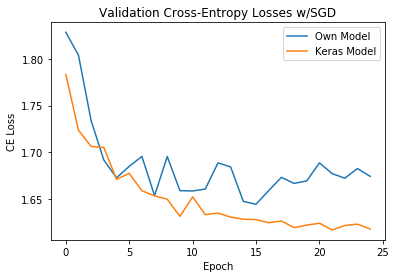

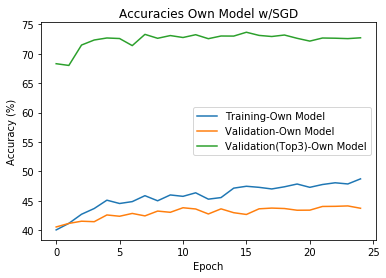

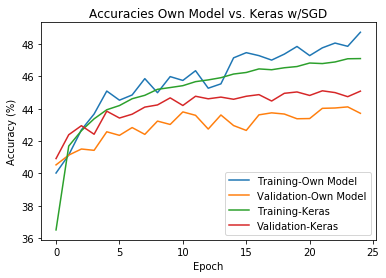

In [34]:
print(hist.history.keys())
plt.plot(ceErrs)
plt.plot(hist.history['val_loss'])
plt.title('Validation Cross-Entropy Losses w/SGD')
plt.xlabel('Epoch')
plt.ylabel('CE Loss')
plt.legend(['Own Model', 'Keras Model'])
plt.show()

plt.plot(trAccs)
plt.plot(valAccs)
plt.plot(valKAccs)
plt.title('Accuracies Own Model w/SGD')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(['Training-Own Model', 'Validation-Own Model', 'Validation(Top3)-Own Model'])
plt.show()

plt.plot(trAccs)
plt.plot(valAccs)
plt.plot(np.asarray(hist.history['accuracy'])*100)
plt.plot(np.asarray(hist.history['val_accuracy'])*100)
plt.title('Accuracies Own Model vs. Keras w/SGD')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(['Training-Own Model', 'Validation-Own Model', 'Training-Keras', 'Validation-Keras'])
plt.show()

In [35]:
np.save('valAcc_SGD.npy', valAccs)

In [36]:
testPred = mlp.prediction(x_test.T)
testAcc = np.sum(testPred.reshape((testPred.shape[0],1)) == y_test)/testPred.shape[0]*100
print(testAcc)

43.801522709372534


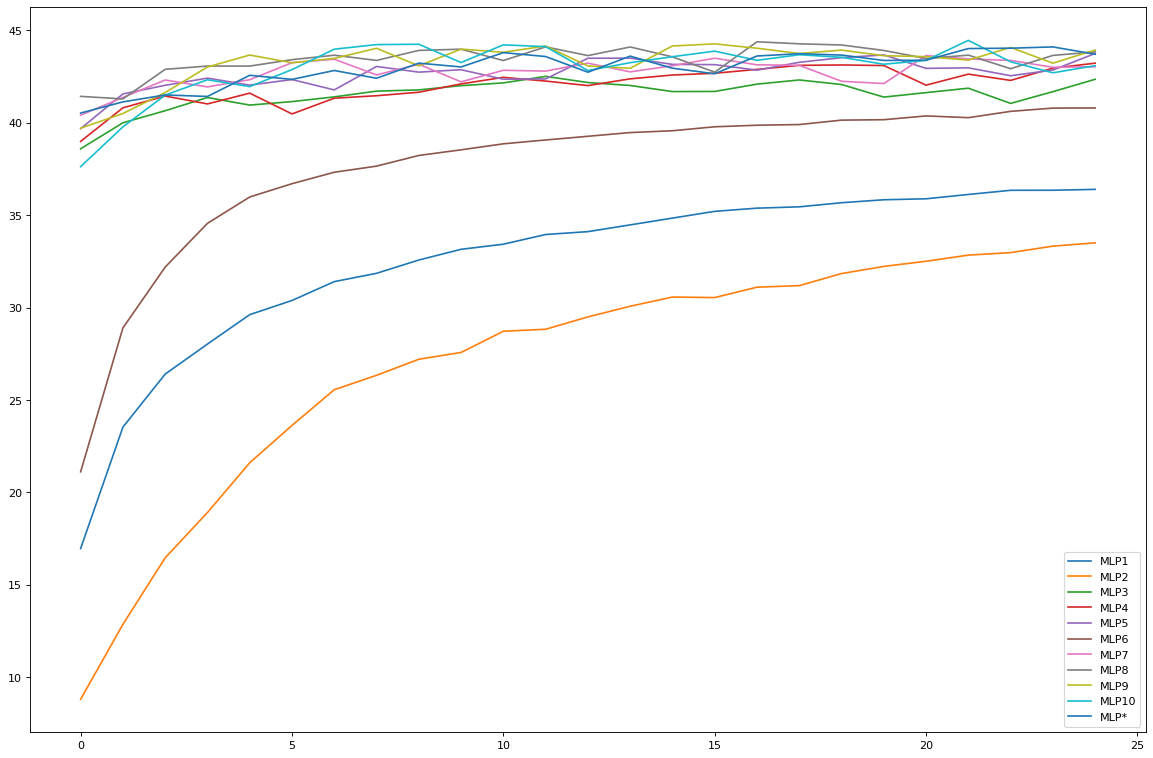

In [39]:
fig=plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(valAccs1)
plt.plot(valAccs2)
plt.plot(valAccs3)
plt.plot(valAccs4)
plt.plot(valAccs5)
plt.plot(valAccs6)
plt.plot(valAccs7)
plt.plot(valAccs8)
plt.plot(valAccs9)
plt.plot(valAccs10)
plt.plot(valAccs)
plt.legend(['MLP1','MLP2','MLP3','MLP4','MLP5','MLP6','MLP7','MLP8','MLP9','MLP10','MLP*'])
plt.show()

In [40]:
print('MLP1\n',mlp1)
print('MLP2\n',mlp2)
print('MLP3\n',mlp3)
print('MLP4\n',mlp4)
print('MLP5\n',mlp5)
print('MLP6\n',mlp6)
print('MLP7\n',mlp7)
print('MLP8\n',mlp8)
print('MLP9\n',mlp9)
print('MLP10\n',mlp10)
print('MLP*\n',mlp)

MLP1
 Layer 0: Input Dim: 11, Number of Neurons: 300
 Activation: sigmoid
Layer 1: Input Dim: 300, Number of Neurons: 23
 Activation: softmax

MLP2
 Layer 0: Input Dim: 11, Number of Neurons: 300
 Activation: sigmoid
Layer 1: Input Dim: 300, Number of Neurons: 100
 Activation: sigmoid
Layer 2: Input Dim: 100, Number of Neurons: 23
 Activation: softmax

MLP3
 Layer 0: Input Dim: 11, Number of Neurons: 300
 Activation: relu
Layer 1: Input Dim: 300, Number of Neurons: 100
 Activation: relu
Layer 2: Input Dim: 100, Number of Neurons: 23
 Activation: softmax

MLP4
 Layer 0: Input Dim: 11, Number of Neurons: 300
 Activation: relu
Layer 1: Input Dim: 300, Number of Neurons: 100
 Activation: relu
Layer 2: Input Dim: 100, Number of Neurons: 23
 Activation: softmax

MLP5
 Layer 0: Input Dim: 11, Number of Neurons: 400
 Activation: relu
Layer 1: Input Dim: 400, Number of Neurons: 200
 Activation: relu
Layer 2: Input Dim: 200, Number of Neurons: 23
 Activation: softmax

MLP6
 Layer 0: Input Dim: 1